##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:
Find the right K for all like bow, tf-idf, avg w2v, tf-idf w2v and also report the test accuracy for the chosen K for all the techniques

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import string
import sqlite3
from sklearn.metrics import confusion_matrix
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import warnings
warnings.filterwarnings("ignore")

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\abc\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Loading the Dataset

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
final.shape

(364171, 10)

In [7]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


### Creating a subset of the data

In [8]:
final=final.iloc[:100000,:]

In [9]:
final.shape

(100000, 10)

In [10]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

In [11]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [12]:
final['Score'].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

### Data Preprocessing

In [41]:
import re
import nltk
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned


print(sno.stem('tasty'))

tasti


In [14]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower()):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [16]:
final.to_pickle('100k_knn_data.pkl')

In [2]:
final=pd.read_pickle('100k_knn_data.pkl')

In [3]:
final.shape


(100000, 11)

In [3]:
final=final.iloc[:50000,:]

In [4]:
X = final["CleanedText"]
y = final["Score"]

In [77]:
print(X)

0        this witti littl book make son laugh loud reci...
1        can rememb see the show when air televis year ...
2        beetlejuic well written movi everyth about exc...
3        twist rumplestiskin captur film star michael k...
4        beetlejuic excel and funni movi keaton hilari ...
5        this one movi that should your movi collect fi...
6        myself alway enjoy this movi it veri funni and...
7        bought few these after apart was infest with f...
8        what happen when you say his name three time m...
9        get crazyim look for beatlejuic french version...
10       get crazi realli imposs today not find the fre...
11       this was realli good idea and the final produc...
12       just receiv shipment and could hard wait tri t...
13       have just recent purchas the woodstream corp g...
14       this are much easier use than the wilson past ...
15       these are easi use they not make mess and offe...
16       this such great film dont even know how sum fi.

In [5]:
import math
X_1=X[:math.ceil(len(final)*.8)]


In [6]:
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(40000,) (40000,) (10000,)


In [7]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(30000,) (30000,) (10000,)


### Calculating K using BOW

In [8]:
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [9]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

### Performing knn using brute force algorithm

In [12]:
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

In [13]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 83%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [14]:
MSE = [100 - x for x in cv_scores]

In [15]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 7.


In [16]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [17]:
pred = knn_optimal.predict(X_test)


In [18]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 86.670000%


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
array=confusion_matrix(y_test, pred)

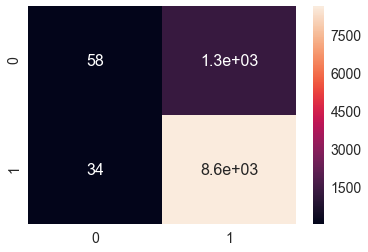

In [30]:
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.show()

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.63      0.04      0.08      1357
   positive       0.87      1.00      0.93      8643

avg / total       0.84      0.87      0.81     10000



### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 58, tp(true positive) = 8600, fn(false negative) = 34, fp(false positive) = 1300
* And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (8600+58)/10000 = ~86.67%
* And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (34+1300)/10000 = ~13.33%
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 8600/9900 = ~86.86%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 8600/8634 = ~99.6%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 58/1357 = ~4.2%. The best specificity is 1.0, whereas the worst is 0.0 .
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1300/1357 = ~95.7%
* F1 score/F-score/F-measure is weighted avg of precision and recall(tpr)=0.928
* support is number of elements in each class(+ve and -ve).

### Performing knn using kd-tree algorithm 


In [10]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
X_train=svd.fit_transform(X_train)
X_test=svd.transform(X_test)
X_CV=svd.transform(X_CV)

In [13]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 81%

CV accuracy for k = 3 is 85%

CV accuracy for k = 5 is 86%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [14]:
MSE = [1 - x for x in cv_scores]

In [15]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


In [16]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [17]:
pred = knn_optimal.predict(X_test)

In [18]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 86.930000%


In [26]:
from sklearn.metrics import f1_score
print("F1 Score is:")
print(f1_score(y_test, pred, average='weighted'))


F1 Score is:
0.818305395353


### Calculating K using tf-idf

In [27]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(40000,) (40000,) (10000,)


In [28]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(30000,) (30000,) (10000,)


In [29]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [30]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

### Performing knn using brute force algorithm

In [43]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 85%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 88%

CV accuracy for k = 7 is 88%

CV accuracy for k = 9 is 88%

CV accuracy for k = 11 is 88%

CV accuracy for k = 13 is 88%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [44]:
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 7.


In [45]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [46]:
pred = knn_optimal.predict(X_test)

In [47]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 87.520000%


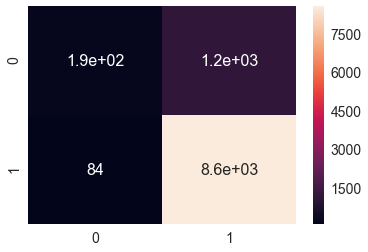

In [48]:
array=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.show()

In [49]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.70      0.14      0.24      1357
   positive       0.88      0.99      0.93      8643

avg / total       0.86      0.88      0.84     10000



### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 190, tp(true positive) = 8600, fn(false negative) = 84, fp(false positive) = 1200
* And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (8600+190)/10000 = ~87.9%
* And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (84+1200)/10000 = ~12.7%
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 8600/9800 = ~87.7%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 8600/8643 = ~99.6%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 190/1357 = ~14%. The best specificity is 1.0, whereas the worst is 0.0 .
* False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1200/1357 = ~88.4%
* F1 score/F-score/F-measure is weighted avg of precision and recall(tpr)=0.92
* support is number of elements in each class(+ve and -ve).

### Performing knn using kd-tree algorithm

In [31]:
svd = TruncatedSVD(n_components=300)
X_train=svd.fit_transform(X_train)
X_test=svd.transform(X_test)
X_CV=svd.transform(X_CV)

In [32]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 79%

CV accuracy for k = 3 is 83%

CV accuracy for k = 5 is 85%

CV accuracy for k = 7 is 86%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [33]:
MSE = [1 - x for x in cv_scores]

In [34]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


In [35]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [36]:
pred = knn_optimal.predict(X_test)

In [37]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 86.700000%


In [38]:
print("F1 Score is:")
print(f1_score(y_test, pred, average='weighted'))


F1 Score is:
0.815508029567


### Calculating K using w2v

In [39]:
from gensim.models import Word2Vec
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(30000,) (30000,) (10000,)


In [42]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [43]:
print(list_of_sent[0])

['this', 'witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'the', 'car', 'were', 'drive', 'along', 'and', 'alway', 'can', 'sing', 'the', 'refrain', 'hes', 'learn', 'about', 'whale', 'india', 'droop', 'rose', 'love', 'all', 'the', 'new', 'word', 'this', 'book', 'introduc', 'and', 'the', 'silli', 'all', 'this', 'classic', 'book', 'will', 'bet', 'son', 'will', 'still', 'abl', 'recit', 'from', 'memori', 'when', 'colleg']


In [44]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [45]:
w2v = list(w2v_model.wv.vocab)

In [46]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  7806


In [47]:
print("sample words ", w2v[0:50])

sample words  ['this', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'the', 'car', 'were', 'drive', 'along', 'and', 'alway', 'can', 'sing', 'hes', 'learn', 'about', 'india', 'rose', 'love', 'all', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'from', 'memori', 'when', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'was', 'child', 'sister', 'later', 'bought', 'which', 'have']


### Average W2V

In [48]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [34:17<00:00, 20.09it/s]


30000
50


In [49]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:34<00:00, 14.41it/s]


10000
50


In [50]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:53<00:00, 15.30it/s]


10000
50


In [51]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV


### Performing knn using brute force algorithm for avg w2v

In [84]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 87%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [85]:
MSE = [1 - x for x in cv_scores]

In [86]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 1.


In [123]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [88]:
pred = knn_optimal.predict(X_test)

In [89]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 13.570000%


In [91]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.14      1.00      0.24      1357
   positive       0.00      0.00      0.00      8643

avg / total       0.02      0.14      0.03     10000



### Performing knn using kd-tree algorithm for avgw2v

In [53]:
svd = TruncatedSVD()
X_train=svd.fit_transform(X_train)
X_test=svd.transform(X_test)
X_CV=svd.transform(X_CV)

In [54]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 12%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [55]:
MSE = [1 - x for x in cv_scores]

In [56]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 3.


In [57]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [58]:
pred = knn_optimal.predict(X_test)

In [59]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 3 is 86.430000%


In [60]:
print("F1 Score is:")
print(f1_score(y_test, pred, average='weighted'))

F1 Score is:
0.801388714263


### tf-idf W2V

In [61]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(30000,) (30000,) (10000,)


In [62]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [63]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1 

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [33:24<00:00, 14.96it/s]


In [64]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1 

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:43<00:00, 14.22it/s]


In [65]:
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1 

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:17<00:00, 14.75it/s]


In [66]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

### Performing knn using brute force algorithm for tf-idf w2v

In [107]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 87%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [108]:
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 1.


In [110]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm = "brute")

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [111]:
pred = knn_optimal.predict(X_test)

In [112]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 86.430000%


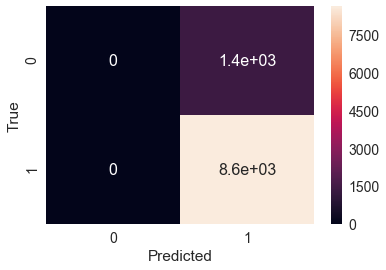

In [115]:
array=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [114]:
print(classification_report(y_test ,pred))


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      1357
   positive       0.86      1.00      0.93      8643

avg / total       0.75      0.86      0.80     10000



### confusion matrix described

In above confusion matrix(used to describe performence of classifier)

* tn(true negative) = 0, tp(true positive) = 8600, fn(false negative) = 0, fp(false positive) = 1400
* And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (8600+0)/10000 = ~86%
* And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (0+1400)/10000 = ~14%
* precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 8600/10000 = ~86%
* True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 8600/8643 = ~99.6%
* Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 0/1357 = ~0%. The best specificity is 1.0, whereas the worst is 0.0 .

* F1 score/F-score/F-measure is weighted avg of precision and recall(tpr)=0.926
* support is number of elements in each class(+ve and -ve).

### Performing knn using kd-tree algorithm for tf-idf w2v

In [67]:
svd = TruncatedSVD()
X_train=svd.fit_transform(X_train)
X_test=svd.transform(X_test)
X_CV=svd.transform(X_CV)

In [68]:
cv_scores = []

    # perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = "kd_tree")
     # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_CV)
     # evaluate CV accuracy
    acc = accuracy_score(y_CV, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    print('\nCV accuracy for k = %d is %d%%' % (k, acc))


CV accuracy for k = 1 is 12%

CV accuracy for k = 3 is 87%

CV accuracy for k = 5 is 87%

CV accuracy for k = 7 is 87%

CV accuracy for k = 9 is 87%

CV accuracy for k = 11 is 87%

CV accuracy for k = 13 is 87%

CV accuracy for k = 15 is 87%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%


In [69]:
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 3.


In [70]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [71]:
pred = knn_optimal.predict(X_test)

In [72]:
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 3 is 86.430000%


In [73]:
print("F1 Score is:")
print(f1_score(y_test, pred, average='weighted'))

F1 Score is:
0.801388714263


### Conclusions:



In [76]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorization_Technique", "Best 'K'", "Accuracy on Test Data(%)", "Algorithm","F1 Score"]

x.add_row(["BOW", 7, 86.670000, 'brute',0.928])
x.add_row(["BOW", 15, 86.670000, 'kd_tree',0.818])
x.add_row(["tf-idf", 7, 87.520000, 'brute',0.932])
x.add_row(["tf-idf", 17, 87.520000, 'kd_tree',0.815])
x.add_row(["Average w2v", 1, 13.570000, 'brute',0.926])
x.add_row(["Average w2v", 3, 13.570000, 'kd_tree',0.801])
x.add_row(["tf-idf w2v", 1, 86.430000, 'brute',0.926])
x.add_row(["tf-idf w2v", 3, 86.430000, 'kd_tree',0.801])

In [77]:
print(x)

+-------------------------+----------+--------------------------+-----------+----------+
| Vectorization_Technique | Best 'K' | Accuracy on Test Data(%) | Algorithm | F1 Score |
+-------------------------+----------+--------------------------+-----------+----------+
|           BOW           |    7     |          86.67           |   brute   |  0.928   |
|           BOW           |    15    |          86.67           |  kd_tree  |  0.818   |
|          tf-idf         |    7     |          87.52           |   brute   |  0.932   |
|          tf-idf         |    17    |          87.52           |  kd_tree  |  0.815   |
|       Average w2v       |    1     |          13.57           |   brute   |  0.926   |
|       Average w2v       |    3     |          13.57           |  kd_tree  |  0.801   |
|        tf-idf w2v       |    1     |          86.43           |   brute   |  0.926   |
|        tf-idf w2v       |    3     |          86.43           |  kd_tree  |  0.801   |
+--------------------

* As we clearly see that for tf-idf accuracy is 87.52 and F1 Score is 0.932(which is maximum). Hence, we conclude that tf-idf vectorization model is good.
